In [ ]:
# @title Cell 1: Setup and Imports

# Install necessary libraries (if not already present in Colab)
!pip install torch torchvision torchaudio numpy pandas scikit-learn matplotlib seaborn scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2, norm # norm for Gaussian visualization

import os
import random # For simulating data

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

print("Setup complete and libraries imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Total samples: 6500, Time steps: 100, Features: 3
Normal samples: 5000, Anomaly samples: 1500
Flattened data shape: (6500, 300)

Shape of normal training data for VAE: (4000, 300)
Shape of full test data: (1300, 300)
Shape of scaled normal training data: (4000, 300)
Shape of scaled test data: (1300, 300)

Simulated data generated, preprocessed, and DataLoaders created.


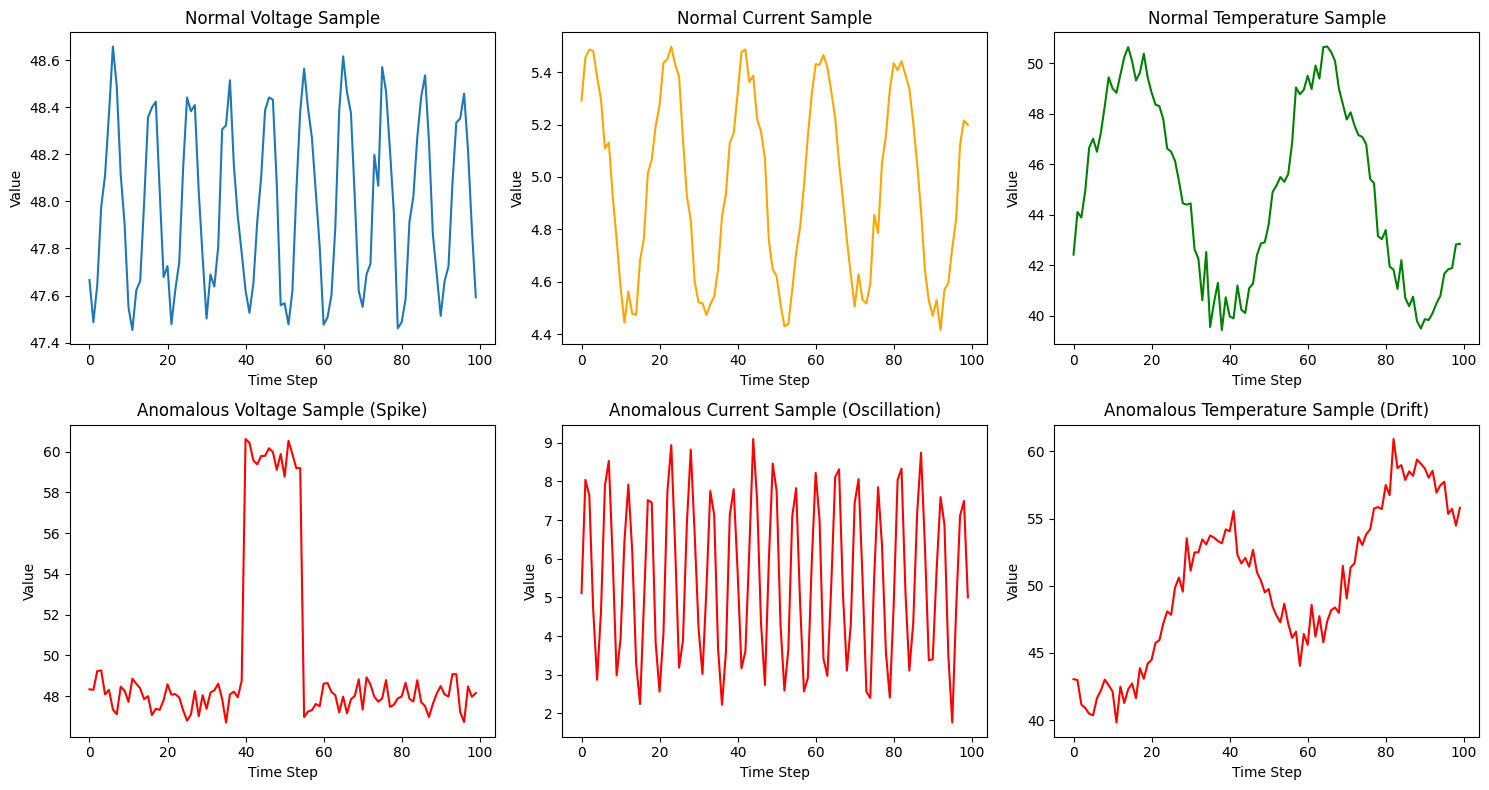

In [ ]:
# @title Cell 2: Simulated Power Converter Sensor Data Generation

# Simulation parameters for a power converter
# Let's imagine we're monitoring a DC-DC converter's output voltage, current, and temperature.
# Normal operation will have stable, periodic signals or signals within a specific range.
# Anomalies might involve spikes, drifts, or increased noise.

NUM_SAMPLES = 5000  # Total number of "operating cycles" or data instances
TIME_STEPS = 100    # Number of sensor readings per sample (time series length)
NUM_FEATURES = 3    # e.g., Output Voltage, Output Current, IGBT Temperature

# --- Generate Normal Operation Data ---
normal_data = np.zeros((NUM_SAMPLES, TIME_STEPS, NUM_FEATURES))

# Feature 1: Output Voltage (e.g., 48V nominal, with ripple/noise)
# Simulate a stable DC voltage with some high-frequency ripple
voltage_base = 48.0
voltage_ripple_amp = 0.5
voltage_noise_std = 0.1
t = np.linspace(0, 2*np.pi, TIME_STEPS)
for i in range(NUM_SAMPLES):
    ripple = voltage_ripple_amp * np.sin(t * 10 + random.uniform(0, 2*np.pi)) # Vary phase slightly
    noise = np.random.normal(0, voltage_noise_std, TIME_STEPS)
    normal_data[i, :, 0] = voltage_base + ripple + noise

# Feature 2: Output Current (e.g., varying load, but within normal limits)
current_base_mean = 5.0
current_base_std = 0.5
current_variation_amp = 1.0 # Simulate load variation
current_noise_std = 0.05
for i in range(NUM_SAMPLES):
    base_current = np.random.normal(current_base_mean, current_base_std)
    variation = current_variation_amp * (np.sin(t * 5 + random.uniform(0, 2*np.pi)) * 0.5 + 0.5) # Varies from 0 to 1
    noise = np.random.normal(0, current_noise_std, TIME_STEPS)
    normal_data[i, :, 1] = base_current + variation + noise

# Feature 3: IGBT Temperature (stable within operating range)
temp_base = 45.0
temp_variation_amp = 5.0
temp_noise_std = 0.5
for i in range(NUM_SAMPLES):
    variation = temp_variation_amp * np.sin(t * 2 + random.uniform(0, 2*np.pi)) # Slower variation
    noise = np.random.normal(0, temp_noise_std, TIME_STEPS)
    normal_data[i, :, 2] = temp_base + variation + noise


# --- Generate Anomalous Data ---
# Let's simulate 3 types of anomalies for 10% of samples
NUM_ANOMALIES = int(NUM_SAMPLES * 0.1)
anomaly_data = np.zeros((NUM_ANOMALIES * 3, TIME_STEPS, NUM_FEATURES)) # 3 types of anomalies
anomaly_labels = np.ones(NUM_ANOMALIES * 3) # 1 for anomaly, 0 for normal

# Anomaly Type 1: Voltage Spike/Drift
# E.g., a momentary overvoltage due to control instability or component degradation
for i in range(NUM_ANOMALIES):
    idx = i
    anomaly_data[idx] = np.copy(normal_data[random.randint(0, NUM_SAMPLES-1)]) # Base on a random normal sample
    spike_start = random.randint(20, 70)
    spike_end = min(spike_start + random.randint(5, 15), TIME_STEPS)
    anomaly_data[idx, spike_start:spike_end, 0] += random.uniform(5, 15) # Add a significant spike/drift
    anomaly_data[idx, :, 0] += np.random.normal(0, 0.5, TIME_STEPS) # Add more noise
    anomaly_labels[idx] = 1

# Anomaly Type 2: Current Instability / Oscillations
# E.g., load instability or a failing component causing oscillations
for i in range(NUM_ANOMALIES):
    idx = NUM_ANOMALIES + i
    anomaly_data[idx] = np.copy(normal_data[random.randint(0, NUM_SAMPLES-1)])
    osc_amp = random.uniform(1.0, 3.0)
    osc_freq = random.uniform(15, 30)
    anomaly_data[idx, :, 1] += osc_amp * np.sin(t * osc_freq)
    anomaly_data[idx, :, 1] += np.random.normal(0, 0.2, TIME_STEPS) # Add more noise
    anomaly_labels[idx] = 1

# Anomaly Type 3: Overheating (Temperature increasing over time)
# E.g., poor cooling, component nearing failure
for i in range(NUM_ANOMALIES):
    idx = NUM_ANOMALIES * 2 + i
    anomaly_data[idx] = np.copy(normal_data[random.randint(0, NUM_SAMPLES-1)])
    temp_increase = np.linspace(0, random.uniform(8, 20), TIME_STEPS) # Linear increase
    anomaly_data[idx, :, 2] += temp_increase
    anomaly_data[idx, :, 2] += np.random.normal(0, 0.8, TIME_STEPS) # Add more noise
    anomaly_labels[idx] = 1


# --- Combine and Prepare Data for Training/Testing ---
X_all = np.concatenate((normal_data, anomaly_data), axis=0)
y_all = np.concatenate((np.zeros(NUM_SAMPLES), anomaly_labels), axis=0) # 0 for normal, 1 for anomaly

print(f"Total samples: {X_all.shape[0]}, Time steps: {TIME_STEPS}, Features: {NUM_FEATURES}")
print(f"Normal samples: {np.sum(y_all == 0)}, Anomaly samples: {np.sum(y_all == 1)}")

# Reshape data for the VAE (flatten time steps and features into one sequence)
X_all_flat = X_all.reshape(X_all.shape[0], -1) # (N_samples, TIME_STEPS * NUM_FEATURES)
print(f"Flattened data shape: {X_all_flat.shape}")

# Split into training and testing sets
# Crucially, ensure normal data is predominantly in training
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_all_flat, y_all, test_size=0.2, random_state=SEED, stratify=y_all
)

# Only train on 'normal' data for the VAE
X_train_normal = X_train_full[y_train_full == 0]
print(f"\nShape of normal training data for VAE: {X_train_normal.shape}")
print(f"Shape of full test data: {X_test_full.shape}")

# Normalize data to [0, 1] range using MinMaxScaler
scaler = MinMaxScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_full) # Apply same scaler to test data

print(f"Shape of scaled normal training data: {X_train_normal_scaled.shape}")
print(f"Shape of scaled test data: {X_test_scaled.shape}")

# Convert to PyTorch tensors
train_tensor = torch.tensor(X_train_normal_scaled, dtype=torch.float32).to(device)
test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_full, dtype=torch.long).to(device)

# Create DataLoader
BATCH_SIZE = 128
train_dataloader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print("\nSimulated data generated, preprocessed, and DataLoaders created.")

# Visualize examples of simulated data
plt.figure(figsize=(15, 8))

# Plot normal samples for each feature
plt.subplot(2, 3, 1)
plt.plot(X_all[np.where(y_all==0)[0][0], :, 0], label='Voltage')
plt.title("Normal Voltage Sample")
plt.xlabel("Time Step")
plt.ylabel("Value")

plt.subplot(2, 3, 2)
plt.plot(X_all[np.where(y_all==0)[0][0], :, 1], label='Current', color='orange')
plt.title("Normal Current Sample")
plt.xlabel("Time Step")
plt.ylabel("Value")

plt.subplot(2, 3, 3)
plt.plot(X_all[np.where(y_all==0)[0][0], :, 2], label='Temperature', color='green')
plt.title("Normal Temperature Sample")
plt.xlabel("Time Step")
plt.ylabel("Value")

# Plot anomaly samples for each feature (one of each type if possible)
anom_idx_v = np.where((y_all==1) & (np.max(X_all[:,:,0], axis=1) > 60))[0][0] # Find a voltage spike
anom_idx_c = np.where((y_all==1) & (np.max(X_all[:,:,1], axis=1) > 9))[0][0] # Find a current oscillation
anom_idx_t = np.where((y_all==1) & (np.max(X_all[:,:,2], axis=1) > 60))[0][0] # Find an overheating sample

plt.subplot(2, 3, 4)
plt.plot(X_all[anom_idx_v, :, 0], color='red')
plt.title("Anomalous Voltage Sample (Spike)")
plt.xlabel("Time Step")
plt.ylabel("Value")

plt.subplot(2, 3, 5)
plt.plot(X_all[anom_idx_c, :, 1], color='red')
plt.title("Anomalous Current Sample (Oscillation)")
plt.xlabel("Time Step")
plt.ylabel("Value")

plt.subplot(2, 3, 6)
plt.plot(X_all[anom_idx_t, :, 2], color='red')
plt.title("Anomalous Temperature Sample (Drift)")
plt.xlabel("Time Step")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

In [ ]:
# @title Cell 3: VAE Model Definition

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder - Simple Dense layers for flattened input
        self.encoder_fc1 = nn.Linear(input_dim, 256)
        self.encoder_fc2 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder - Reconstructs flattened input
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 256)
        self.decoder_fc3 = nn.Linear(256, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() # Output activation for [0,1] normalized data

    def encode(self, x):
        h1 = self.relu(self.encoder_fc1(x))
        h2 = self.relu(self.encoder_fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample from standard normal
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.decoder_fc1(z))
        h4 = self.relu(self.decoder_fc2(h3))
        return self.sigmoid(self.decoder_fc3(h4))

    def forward(self, x):
        # x is already flattened in the dataloader
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Model parameters
INPUT_DIM = TIME_STEPS * NUM_FEATURES # e.g., 100 * 3 = 300
LATENT_DIM = 8 # A good balance, can be 2 for easier 2D visualization

model = VAE(INPUT_DIM, LATENT_DIM).to(device)
print(f"VAE model initialized with input_dim={INPUT_DIM}, latent_dim={LATENT_DIM}")
print(model)

VAE model initialized with input_dim=300, latent_dim=8
VAE(
  (encoder_fc1): Linear(in_features=300, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=8, bias=True)
  (decoder_fc1): Linear(in_features=8, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=256, bias=True)
  (decoder_fc3): Linear(in_features=256, out_features=300, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


Starting VAE training...
Epoch 1/100, Train Loss: 15.3061
Epoch 2/100, Train Loss: 13.8362
Epoch 3/100, Train Loss: 10.5457
Epoch 4/100, Train Loss: 9.8199
Epoch 5/100, Train Loss: 9.0196
Epoch 6/100, Train Loss: 8.5211
Epoch 7/100, Train Loss: 8.3122
Epoch 8/100, Train Loss: 8.1841
Epoch 9/100, Train Loss: 8.0211
Epoch 10/100, Train Loss: 8.0069
Epoch 11/100, Train Loss: 7.9190
Epoch 12/100, Train Loss: 7.9401
Epoch 13/100, Train Loss: 7.9191
Epoch 14/100, Train Loss: 7.9044
Epoch 15/100, Train Loss: 7.8647
Epoch 16/100, Train Loss: 7.8553
Epoch 17/100, Train Loss: 7.8410
Epoch 18/100, Train Loss: 7.8339
Epoch 19/100, Train Loss: 7.8095
Epoch 20/100, Train Loss: 7.7846
Epoch 21/100, Train Loss: 7.8348
Epoch 22/100, Train Loss: 7.8122
Epoch 23/100, Train Loss: 7.7507
Epoch 24/100, Train Loss: 7.7594
Epoch 25/100, Train Loss: 7.6896
Epoch 26/100, Train Loss: 7.7416
Epoch 27/100, Train Loss: 7.6873
Epoch 28/100, Train Loss: 7.7714
Epoch 29/100, Train Loss: 7.6642
Epoch 30/100, Train Loss

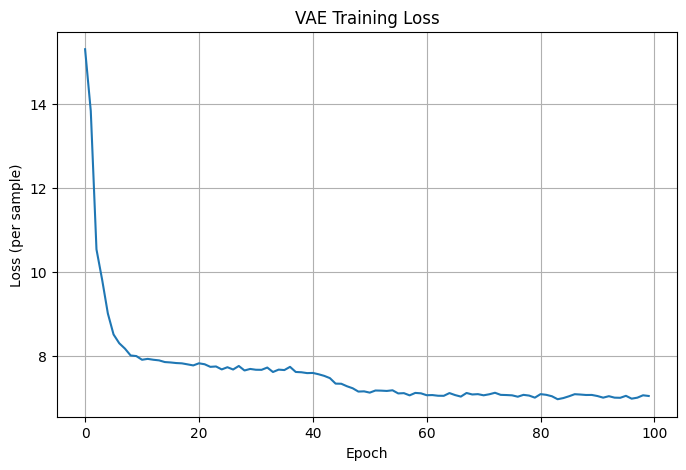

In [ ]:
# @title Cell 4: VAE Loss Function and Training

def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: Mean Squared Error (MSE) is common for continuous sensor data
    # (though BCE can also be used if data is strictly [0,1] and output is sigmoid)
    # Using 'sum' reduction for consistency with KL divergence, then normalize by batch size
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') # x.view(-1, INPUT_DIM) if input wasn't flattened

    # KL Divergence loss: D_KL(Q(z|X) || P(z))
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

# Training parameters
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100 # Can adjust based on convergence (e.g., 50-200)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting VAE training...")
history = {'train_loss': []}

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() # Accumulate sum of loss for the batch

    avg_train_loss = train_loss / len(train_dataloader.dataset) # Divide by total samples
    history['train_loss'].append(avg_train_loss)
    print(f'Epoch {epoch}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}')

print("VAE training complete.")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'])
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (per sample)')
plt.grid(True)
plt.show()

In [ ]:
# @title Cell 5: Anomaly Score Calculation

model.eval() # Set model to evaluation mode

# --- 1. Extract Latent Features for Normal Training Data ---
normal_latent_vectors = []
with torch.no_grad():
    for data, in train_dataloader:
        data = data.to(device)
        mu, _ = model.encode(data) # We only need mu for the latent representation
        normal_latent_vectors.append(mu.cpu().numpy())

normal_latent_vectors = np.concatenate(normal_latent_vectors, axis=0)
print(f"Shape of normal latent vectors (training data): {normal_latent_vectors.shape}")

# --- 2. Calculate Mean and Covariance Matrix of Normal Latent Space ---
mu_normal_latent = np.mean(normal_latent_vectors, axis=0)
# Ensure covariance matrix is positive definite (add small identity for numerical stability)
cov_normal_latent = np.cov(normal_latent_vectors, rowvar=False) + np.eye(LATENT_DIM) * 1e-6
inv_cov_normal_latent = np.linalg.inv(cov_normal_latent)

print(f"Mean of normal latent space (mu_normal_latent): {mu_normal_latent.shape}")
print(f"Covariance matrix of normal latent space (cov_normal_latent): {cov_normal_latent.shape}")


# --- 3. Compute Anomaly Scores for Test Data ---
test_latent_vectors = []
reconstruction_errors = []
with torch.no_grad():
    for data, labels in test_dataloader:
        data = data.to(device)
        recon_data, mu, logvar = model(data)
        test_latent_vectors.append(mu.cpu().numpy())

        # Calculate reconstruction error (MSE per sample)
        # Reshape data to original dimensions for meaningful MSE per sample
        mse_loss = nn.functional.mse_loss(recon_data, data, reduction='none').sum(dim=1)
        reconstruction_errors.append(mse_loss.cpu().numpy())

test_latent_vectors = np.concatenate(test_latent_vectors, axis=0)
reconstruction_errors = np.concatenate(reconstruction_errors, axis=0)

# --- 4. Calculate Euclidean Distance in Latent Space ---
euclidean_distances = np.linalg.norm(test_latent_vectors - mu_normal_latent, axis=1)

# --- 5. Calculate Mahalanobis Distance in Latent Space ---
mahalanobis_distances = np.array([
    mahalanobis(vec, mu_normal_latent, inv_cov_normal_latent) for vec in test_latent_vectors
])

print(f"\nCalculated Euclidean distances for {euclidean_distances.shape[0]} test samples.")
print(f"Calculated Mahalanobis distances for {mahalanobis_distances.shape[0]} test samples.")
print(f"Calculated Reconstruction Errors for {reconstruction_errors.shape[0]} test samples.")

# Store all scores and true labels
anomaly_scores_df = pd.DataFrame({
    'reconstruction_error': reconstruction_errors,
    'euclidean_distance': euclidean_distances,
    'mahalanobis_distance': mahalanobis_distances,
    'true_label': y_test_full # Use the original y_test_full from numpy
})

print("\nSample of anomaly scores DataFrame:")
print(anomaly_scores_df.head())

Shape of normal latent vectors (training data): (4000, 8)
Mean of normal latent space (mu_normal_latent): (8,)
Covariance matrix of normal latent space (cov_normal_latent): (8, 8)

Calculated Euclidean distances for 1300 test samples.
Calculated Mahalanobis distances for 1300 test samples.
Calculated Reconstruction Errors for 1300 test samples.

Sample of anomaly scores DataFrame:
   reconstruction_error  euclidean_distance  mahalanobis_distance  true_label
0              2.318199            2.092180              2.978017         0.0
1              3.795196            1.635558              1.973558         0.0
2              4.423311            2.031825              2.749686         0.0
3              3.162109            1.930679              2.558106         0.0
4              2.329862            2.166116              2.787861         0.0


In [ ]:
# @title Cell 6: Anomaly Detection Performance Evaluation (MODIFIED FULL CODE - Numerical Only)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

print("Evaluating anomaly detection performance...")

# --- Calculate AUCs for Reconstruction Error ---
scores_re = anomaly_scores_df['reconstruction_error'].values
true_labels = anomaly_scores_df['true_label'].values

fpr_re, tpr_re, _ = roc_curve(true_labels, scores_re)
roc_auc_re = auc(fpr_re, tpr_re)
precision_re, recall_re, _ = precision_recall_curve(true_labels, scores_re)
pr_auc_re = average_precision_score(true_labels, scores_re)

# --- Calculate AUCs for Latent Euclidean Distance ---
scores_eu = anomaly_scores_df['euclidean_distance'].values

fpr_eu, tpr_eu, _ = roc_curve(true_labels, scores_eu)
roc_auc_eu = auc(fpr_eu, tpr_eu)
precision_eu, recall_eu, _ = precision_recall_curve(true_labels, scores_eu)
pr_auc_eu = average_precision_score(true_labels, scores_eu)

# --- Calculate AUCs for Latent Mahalanobis Distance ---
scores_ma = anomaly_scores_df['mahalanobis_distance'].values

fpr_ma, tpr_ma, _ = roc_curve(true_labels, scores_ma)
roc_auc_ma = auc(fpr_ma, tpr_ma)
precision_ma, recall_ma, _ = precision_recall_curve(true_labels, scores_ma)
pr_auc_ma = average_precision_score(true_labels, scores_ma)

# --- Print all AUC values ---
print("\n--- Anomaly Score Performance (AUCs) ---")
print(f"Reconstruction Error:")
print(f"  ROC AUC: {roc_auc_re:.4f}")
print(f"  PR AUC: {pr_auc_re:.4f}")
print("-" * 30)
print(f"Latent Euclidean Distance:")
print(f"  ROC AUC: {roc_auc_eu:.4f}")
print(f"  PR AUC: {pr_auc_eu:.4f}")
print("-" * 30)
print(f"Latent Mahalanobis Distance:")
print(f"  ROC AUC: {roc_auc_ma:.4f}")
print(f"  PR AUC: {pr_auc_ma:.4f}")
print("-" * 30)


print("\nAnomaly detection evaluation complete. (Detailed score distributions in next cell).")

Evaluating anomaly detection performance...

--- Anomaly Score Performance (AUCs) ---
Reconstruction Error:
  ROC AUC: 0.9943
  PR AUC: 0.9833
------------------------------
Latent Euclidean Distance:
  ROC AUC: 0.7574
  PR AUC: 0.6422
------------------------------
Latent Mahalanobis Distance:
  ROC AUC: 0.7794
  PR AUC: 0.6751
------------------------------

Anomaly detection evaluation complete. (Detailed score distributions in next cell).



Visualizing Anomaly Detection Performance and Latent Space...

Plotting Combined ROC and PR Curves...


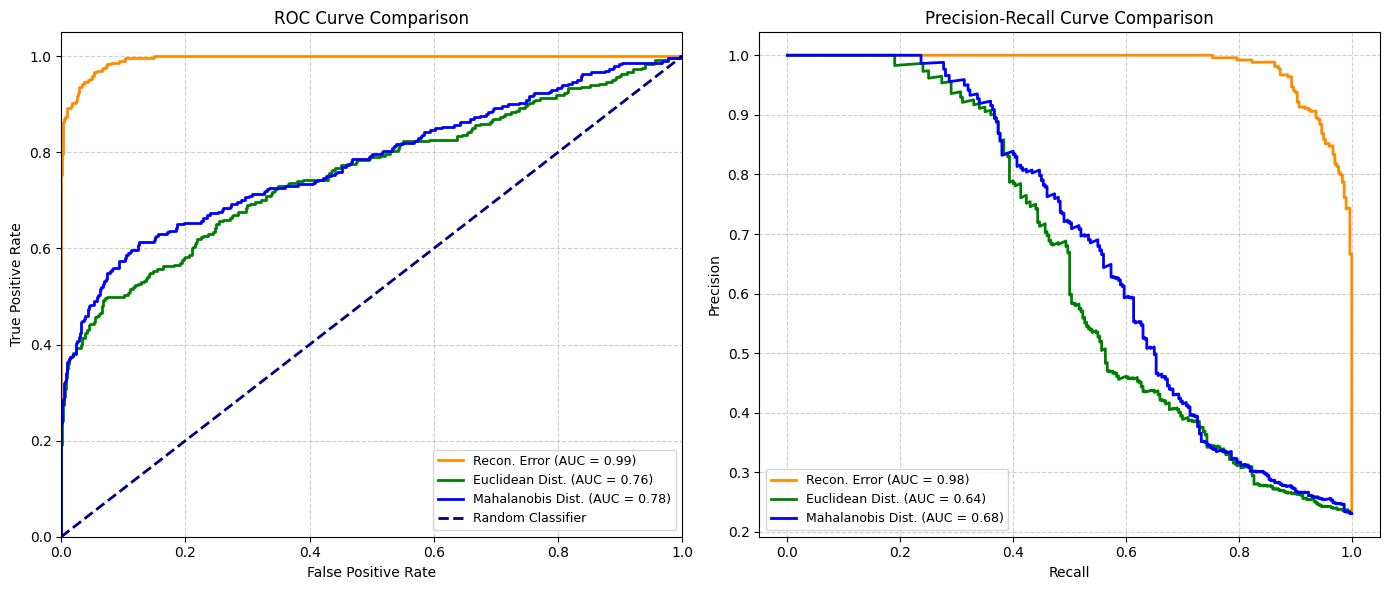


Latent Dimension (8) is too high for direct 2D/3D visualization. Consider using dimensionality reduction (t-SNE/UMAP) for projection in a real paper, but skipping for brevity.

Visualizations complete.


In [ ]:
# @title Cell 7: Visualization of Anomaly Detection Performance (MODIFIED - No Histograms, Focus on ROC & PR - FULL CODE)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\nVisualizing Anomaly Detection Performance and Latent Space...")

# --- 1. Combined ROC and PR Curves (Figure 1 in this modified setup) ---
print("\nPlotting Combined ROC and PR Curves...")
plt.figure(figsize=(14, 6)) # A good size for two side-by-side plots

# --- ROC Curve Comparison ---
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
# ROC for Reconstruction Error
fpr_re, tpr_re, _ = roc_curve(anomaly_scores_df['true_label'], anomaly_scores_df['reconstruction_error'])
roc_auc_re = auc(fpr_re, tpr_re)
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label=f'Recon. Error (AUC = {roc_auc_re:.2f})')

# ROC for Latent Euclidean Distance
fpr_eu, tpr_eu, _ = roc_curve(anomaly_scores_df['true_label'], anomaly_scores_df['euclidean_distance'])
roc_auc_eu = auc(fpr_eu, tpr_eu)
plt.plot(fpr_eu, tpr_eu, color='green', lw=2, label=f'Euclidean Dist. (AUC = {roc_auc_eu:.2f})')

# ROC for Latent Mahalanobis Distance
fpr_ma, tpr_ma, _ = roc_curve(anomaly_scores_df['true_label'], anomaly_scores_df['mahalanobis_distance'])
roc_auc_ma = auc(fpr_ma, tpr_ma)
plt.plot(fpr_ma, tpr_ma, color='blue', lw=2, label=f'Mahalanobis Dist. (AUC = {roc_auc_ma:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve Comparison', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)


# --- PR Curve Comparison ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# PR for Reconstruction Error
precision_re, recall_re, _ = precision_recall_curve(anomaly_scores_df['true_label'], anomaly_scores_df['reconstruction_error'])
pr_auc_re = average_precision_score(anomaly_scores_df['true_label'], anomaly_scores_df['reconstruction_error'])
plt.plot(recall_re, precision_re, color='darkorange', lw=2, label=f'Recon. Error (AUC = {pr_auc_re:.2f})')

# PR for Latent Euclidean Distance
precision_eu, recall_eu, _ = precision_recall_curve(anomaly_scores_df['true_label'], anomaly_scores_df['euclidean_distance'])
pr_auc_eu = average_precision_score(anomaly_scores_df['true_label'], anomaly_scores_df['euclidean_distance'])
plt.plot(recall_eu, precision_eu, color='green', lw=2, label=f'Euclidean Dist. (AUC = {pr_auc_eu:.2f})')

# PR for Latent Mahalanobis Distance
precision_ma, recall_ma, _ = precision_recall_curve(anomaly_scores_df['true_label'], anomaly_scores_df['mahalanobis_distance'])
pr_auc_ma = average_precision_score(anomaly_scores_df['true_label'], anomaly_scores_df['mahalanobis_distance'])
plt.plot(recall_ma, precision_ma, color='blue', lw=2, label=f'Mahalanobis Dist. (AUC = {pr_auc_ma:.2f})')

plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.title('Precision-Recall Curve Comparison', fontsize=12)
plt.legend(loc="lower left", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Ensures everything fits
plt.show()


# --- 2. Latent Space Visualization (Only if LATENT_DIM is 2) ---
if LATENT_DIM == 2: # Specifically target 2D for easy visualization
    print(f"\nVisualizing 2D Latent Space...")
    num_display_samples = 2000 # Max samples to plot for clarity
    display_indices = np.random.choice(len(test_latent_vectors), min(len(test_latent_vectors), num_display_samples), replace=False)
    display_latent_vectors = test_latent_vectors[display_indices]
    display_labels = y_test_full[display_indices]

    plt.figure(figsize=(8, 7)) # Adjusted figure size
    sns.scatterplot(
        x=display_latent_vectors[:, 0],
        y=display_latent_vectors[:, 1],
        hue=display_labels,
        palette={0: 'blue', 1: 'red'}, # 0: Normal, 1: Anomaly
        alpha=0.6,
        s=40,
        legend='full'
    )
    plt.title('2D Latent Space Visualization (Color by True Label)', fontsize=12)
    plt.xlabel('Latent Dimension 1', fontsize=10)
    plt.ylabel('Latent Dimension 2', fontsize=10)
    plt.legend(title='True Label', labels=['Normal', 'Anomaly'], fontsize=9, title_fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
elif LATENT_DIM == 3:
    print(f"\nLatent Dimension is 3. Consider using interactive 3D plot tools if needed, but 2D is simpler for paper.")
else:
    print(f"\nLatent Dimension ({LATENT_DIM}) is too high for direct 2D/3D visualization. Consider using dimensionality reduction (t-SNE/UMAP) for projection in a real paper, but skipping for brevity.")

print("\nVisualizations complete.")

Performing advanced analysis...


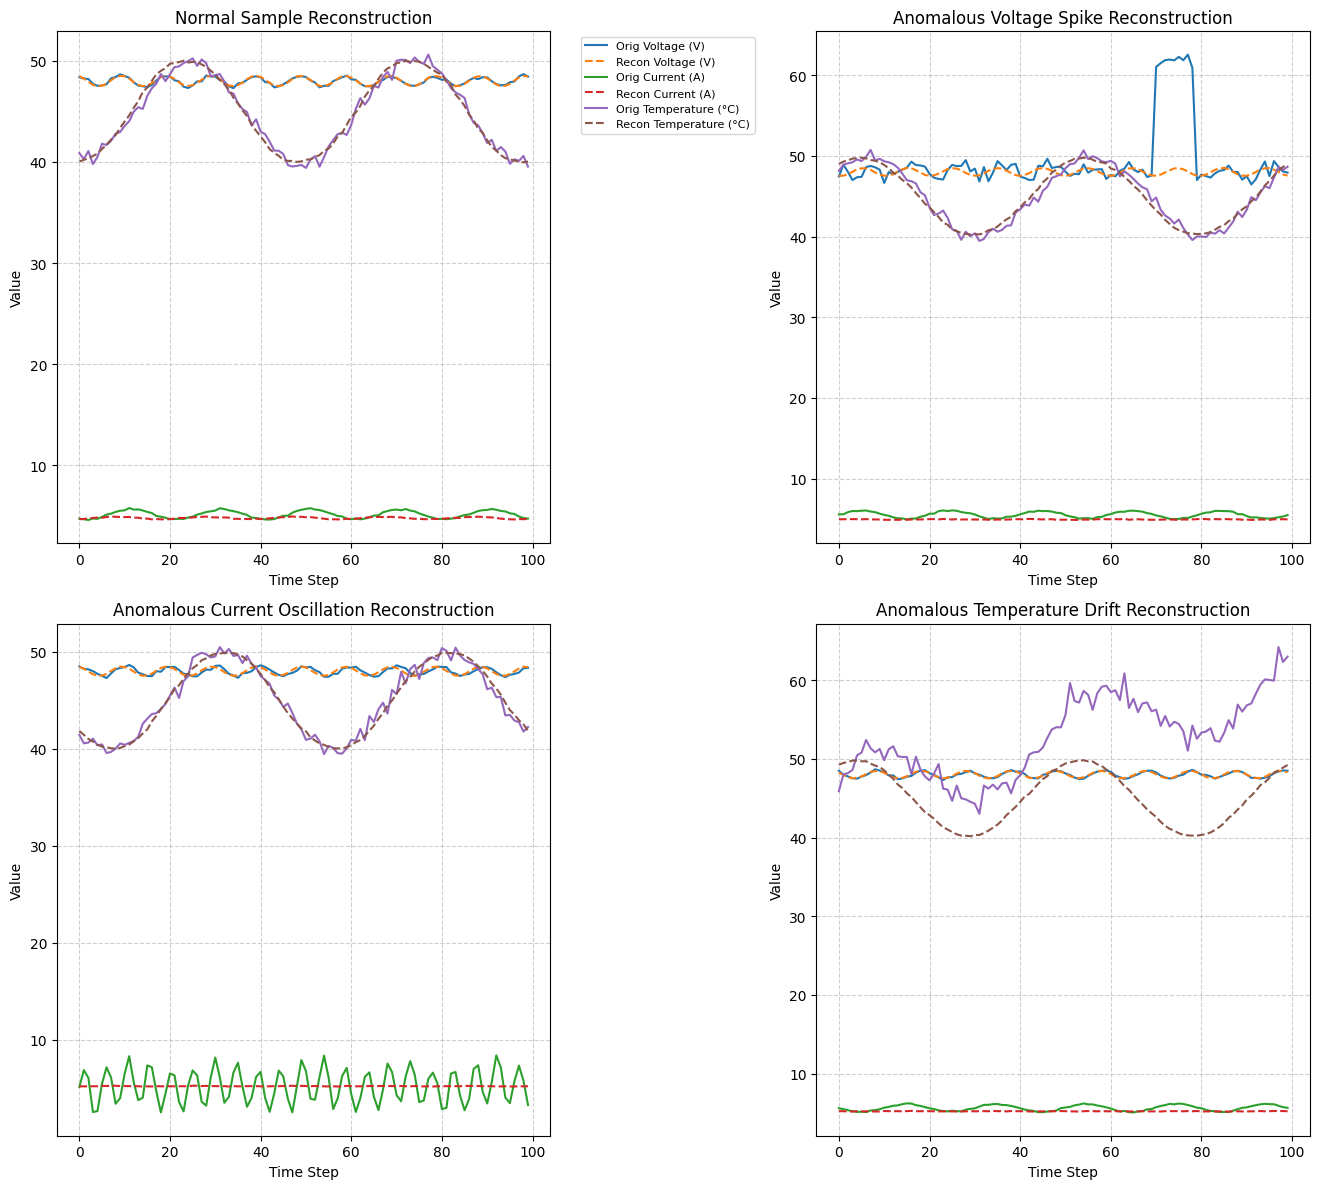


--- Practical Anomaly Thresholding (using Reconstruction Error) ---
Chosen Reconstruction Error Threshold (99th percentile of normal training data): 8.6399

Classification Report for Reconstruction Error (Threshold: 8.6399):
              precision    recall  f1-score   support

  Normal (0)       0.97      0.98      0.98      1000
 Anomaly (1)       0.93      0.90      0.92       300

    accuracy                           0.96      1300
   macro avg       0.95      0.94      0.95      1300
weighted avg       0.96      0.96      0.96      1300


Confusion Matrix:


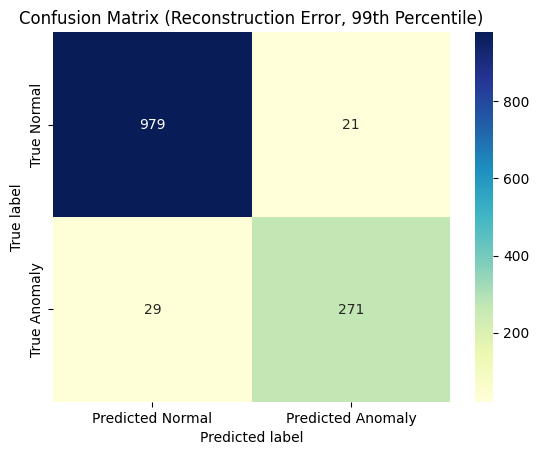


Advanced analysis complete.


In [ ]:
# @title Cell 8: Advanced Analysis: Reconstruction Quality and Thresholding (MODIFIED for 2x2 Reconstruction Plots - FULL CODE)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Performing advanced analysis...")

# --- 1. Visualizing Reconstruction Quality (4 Subplots: 1 Normal, 3 Anomalous Types) ---
# Select one normal sample
normal_sample_idx = np.where(y_test_full == 0)[0][0] # First normal sample in test set

# Select one sample for each anomaly type from the test set
# (These indices need to be carefully chosen to represent the specific anomaly)
# We'll try to find an index that matches the anomaly characteristics from the simulated data generation in Cell 2
# Note: These indices are based on the *simulated* anomaly characteristics, assuming they pass into the test set
# and are distinct enough. In a real scenario, you'd pick based on actual fault labels.

# Find an anomalous voltage sample (spike/drift)
anom_idx_voltage = np.where((y_test_full == 1) & (scaler.inverse_transform(X_test_scaled).reshape(-1, TIME_STEPS, NUM_FEATURES)[:,:,0].max(axis=1) > 60))[0]
anom_idx_voltage = anom_idx_voltage[0] if len(anom_idx_voltage) > 0 else np.where(y_test_full == 1)[0][0] # Fallback if not found

# Find an anomalous current sample (oscillation)
anom_idx_current = np.where((y_test_full == 1) & (scaler.inverse_transform(X_test_scaled).reshape(-1, TIME_STEPS, NUM_FEATURES)[:,:,1].max(axis=1) > 8))[0] # Max current > 8 (normal was ~6)
anom_idx_current = anom_idx_current[0] if len(anom_idx_current) > 0 else np.where(y_test_full == 1)[0][1] # Fallback

# Find an anomalous temperature sample (drift)
anom_idx_temp = np.where((y_test_full == 1) & (scaler.inverse_transform(X_test_scaled).reshape(-1, TIME_STEPS, NUM_FEATURES)[:,:,2].max(axis=1) > 60))[0] # Max temp > 60 (normal was ~50)
anom_idx_temp = anom_idx_temp[0] if len(anom_idx_temp) > 0 else np.where(y_test_full == 1)[0][2] # Fallback

# Create a list of selected indices and their titles
selected_samples_info = [
    (normal_sample_idx, "Normal Sample Reconstruction"),
    (anom_idx_voltage, "Anomalous Voltage Spike Reconstruction"),
    (anom_idx_current, "Anomalous Current Oscillation Reconstruction"),
    (anom_idx_temp, "Anomalous Temperature Drift Reconstruction")
]

plt.figure(figsize=(14, 12)) # Adjusted figure size for a 2x2 grid

feature_names = ['Voltage (V)', 'Current (A)', 'Temperature (°C)']

for i, (sample_idx, title_text) in enumerate(selected_samples_info):
    original_scaled_sample = X_test_scaled[sample_idx:sample_idx+1] # Keep as batch of 1

    # Reconstruct the sample
    model.eval()
    with torch.no_grad():
        recon_scaled_sample, _, _ = model(torch.tensor(original_scaled_sample, dtype=torch.float32).to(device))

    # Convert back to numpy and unscale for plotting
    original_sample = scaler.inverse_transform(original_scaled_sample).reshape(TIME_STEPS, NUM_FEATURES)
    recon_sample = scaler.inverse_transform(recon_scaled_sample.cpu().numpy()).reshape(TIME_STEPS, NUM_FEATURES)

    plt.subplot(2, 2, i + 1) # 2 rows, 2 columns, current plot index
    for j in range(NUM_FEATURES):
        plt.plot(original_sample[:, j], label=f'Orig {feature_names[j]}', linestyle='-')
        plt.plot(recon_sample[:, j], label=f'Recon {feature_names[j]}', linestyle='--')
    plt.title(title_text, fontsize=12)
    plt.xlabel('Time Step', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    if i == 0: # Add legend only to the first plot for clarity
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legend
plt.show()


# --- 2. Practical Anomaly Thresholding and Classification Report (using Reconstruction Error - no changes here) ---
print("\n--- Practical Anomaly Thresholding (using Reconstruction Error) ---")

# Determine threshold based on the distribution of NORMAL data's Reconstruction Errors
# Calculate reconstruction errors for the *normal training data* explicitly
train_normal_reconstruction_errors = []
model.eval() # Ensure model is in eval mode
with torch.no_grad():
    for data, in train_dataloader: # Iterate through the normal training data
        data = data.to(device)
        recon_data, _, _ = model(data)
        mse_loss = nn.functional.mse_loss(recon_data, data, reduction='none').sum(dim=1)
        train_normal_reconstruction_errors.append(mse_loss.cpu().numpy())
train_normal_reconstruction_errors = np.concatenate(train_normal_reconstruction_errors)


# Use Percentile-based Threshold (e.g., 99th percentile of normal training data's reconstruction errors)
percentile = 99 # You can change this to 95, 90, etc. to observe trade-offs
chosen_threshold_re = np.percentile(train_normal_reconstruction_errors, percentile)
print(f"Chosen Reconstruction Error Threshold ({percentile}th percentile of normal training data): {chosen_threshold_re:.4f}")

# Classify test samples based on the chosen threshold
predicted_anomalies_re = (anomaly_scores_df['reconstruction_error'] > chosen_threshold_re).astype(int)

print(f"\nClassification Report for Reconstruction Error (Threshold: {chosen_threshold_re:.4f}):")
print(classification_report(anomaly_scores_df['true_label'], predicted_anomalies_re, target_names=['Normal (0)', 'Anomaly (1)']))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(anomaly_scores_df['true_label'], predicted_anomalies_re)
sns.heatmap(conf_matrix, annot=True, fmt='d', # 'd' for integer format
            cmap='YlGnBu', # Changed colormap for better visuals
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.title(f'Confusion Matrix (Reconstruction Error, {percentile}th Percentile)', fontsize=12) # Added percentile to title
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

print("\nAdvanced analysis complete.")